# Predictive Model for Student Starting Salaries

Authors: Eliska Patockova, Roshan Ravi, Alexa Muratyan

In [46]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal as mvn
from matplotlib import pylab as plt
from itertools import combinations

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

Link to our dataset: https://www.kaggle.com/datasets/benroshan/factors-affecting-campus-placement

## Load the Dataset

In [3]:
data = pd.read_csv("./Placement_Data_Full_Class.csv")
print(data.head())

   sl_no gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p  \
0      1      M  67.00   Others  91.00   Others  Commerce     58.00   
1      2      M  79.33  Central  78.33   Others   Science     77.48   
2      3      M  65.00  Central  68.00  Central      Arts     64.00   
3      4      M  56.00  Central  52.00  Central   Science     52.00   
4      5      M  85.80  Central  73.60  Central  Commerce     73.30   

    degree_t workex  etest_p specialisation  mba_p      status    salary  
0   Sci&Tech     No     55.0         Mkt&HR  58.80      Placed  270000.0  
1   Sci&Tech    Yes     86.5        Mkt&Fin  66.28      Placed  200000.0  
2  Comm&Mgmt     No     75.0        Mkt&Fin  57.80      Placed  250000.0  
3   Sci&Tech     No     66.0         Mkt&HR  59.43  Not Placed       NaN  
4  Comm&Mgmt     No     96.8        Mkt&Fin  55.50      Placed  425000.0  


# Preprocessing

## Analysis of Distributions

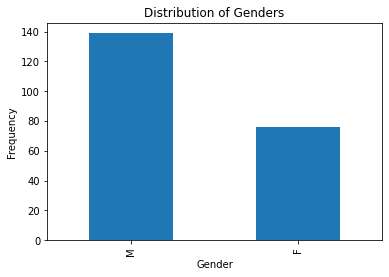

In [5]:
data.loc[:, "gender"].value_counts().plot(kind="bar")
plt.title("Distribution of Genders")
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.show()

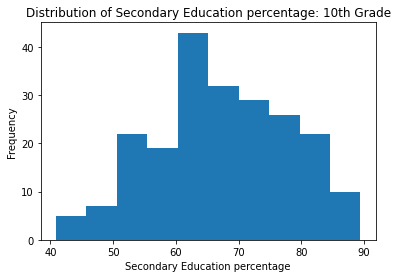

In [9]:
x= data.loc[:, "ssc_p"]
plt.hist(x)
plt.title("Distribution of Secondary Education percentage: 10th Grade")
plt.xlabel("Secondary Education percentage")
plt.ylabel("Frequency")
plt.show()

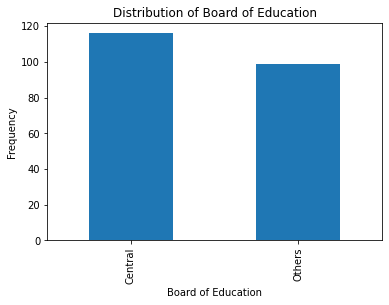

In [10]:
data.loc[:, "ssc_b"].value_counts().plot(kind="bar")
plt.title("Distribution of Board of Education for Secondary")
plt.xlabel("Board of Education")
plt.ylabel("Frequency")
plt.show()

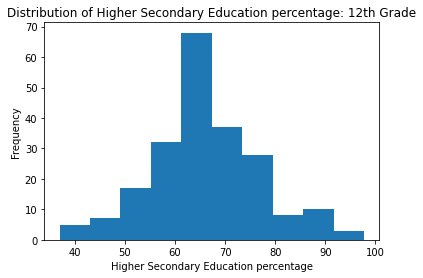

In [11]:
x= data.loc[:, "hsc_p"]
plt.hist(x)
plt.title("Distribution of Higher Secondary Education percentage: 12th Grade")
plt.xlabel("Higher Secondary Education percentage")
plt.ylabel("Frequency")
plt.show()

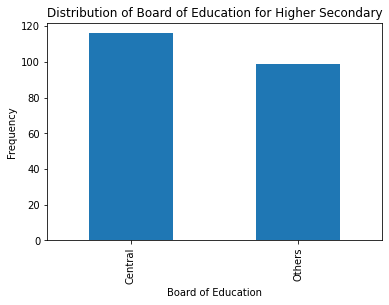

In [12]:
data.loc[:, "ssc_b"].value_counts().plot(kind="bar")
plt.title("Distribution of Board of Education for Higher Secondary")
plt.xlabel("Board of Education")
plt.ylabel("Frequency")
plt.show()

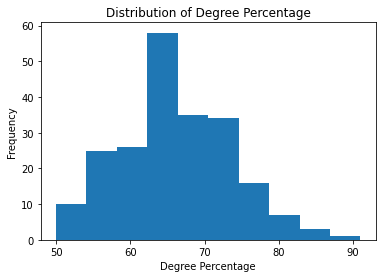

In [13]:
x= data.loc[:, "degree_p"]
plt.hist(x)
plt.title("Distribution of Degree Percentage")
plt.xlabel("Degree Percentage")
plt.ylabel("Frequency")
plt.show()

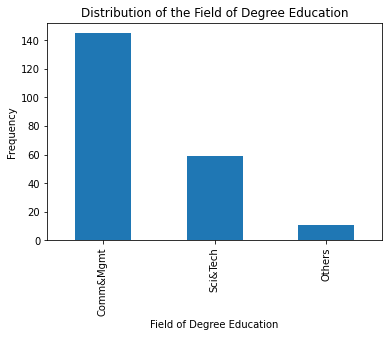

In [14]:
data.loc[:, "degree_t"].value_counts().plot(kind="bar")
plt.title("Distribution of the Field of Degree Education")
plt.xlabel("Field of Degree Education")
plt.ylabel("Frequency")
plt.show()

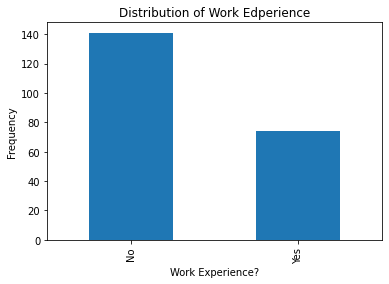

In [15]:
data.loc[:, "workex"].value_counts().plot(kind="bar")
plt.title("Distribution of Work Edperience")
plt.xlabel("Work Experience?")
plt.ylabel("Frequency")
plt.show()

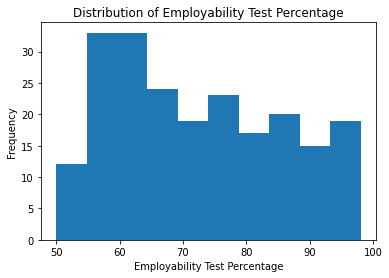

In [16]:
x= data.loc[:, "etest_p"]
plt.hist(x)
plt.title("Distribution of Employability Test Percentage")
plt.xlabel("Employability Test Percentage")
plt.ylabel("Frequency")
plt.show()

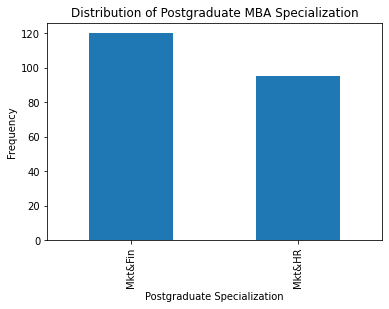

In [19]:
data.loc[:, "specialisation"].value_counts().plot(kind="bar")
plt.title("Distribution of Postgraduate MBA Specialization")
plt.xlabel("Postgraduate Specialization")
plt.ylabel("Frequency")
plt.show()

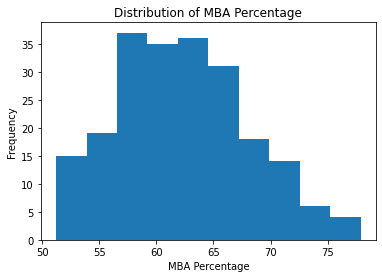

In [20]:
x= data.loc[:, "mba_p"]
plt.hist(x)
plt.title("Distribution of MBA Percentage")
plt.xlabel("MBA Percentage")
plt.ylabel("Frequency")
plt.show()

# Maintain Only Relevant Rows

We are using KNN to predict the best estimation of a student's salary after graduation. 31% of students are not placed in jobs and hence their "salary" is left blank. We want to discard these unplaced student rows.

In [36]:
non_null_salary_data = data[data['status'] == "Placed"]
print(non_null_salary_data.head())

   sl_no gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p  \
0      1      M  67.00   Others  91.00   Others  Commerce     58.00   
1      2      M  79.33  Central  78.33   Others   Science     77.48   
2      3      M  65.00  Central  68.00  Central      Arts     64.00   
4      5      M  85.80  Central  73.60  Central  Commerce     73.30   
7      8      M  82.00  Central  64.00  Central   Science     66.00   

    degree_t workex  etest_p specialisation  mba_p  status    salary  
0   Sci&Tech     No     55.0         Mkt&HR  58.80  Placed  270000.0  
1   Sci&Tech    Yes     86.5        Mkt&Fin  66.28  Placed  200000.0  
2  Comm&Mgmt     No     75.0        Mkt&Fin  57.80  Placed  250000.0  
4  Comm&Mgmt     No     96.8        Mkt&Fin  55.50  Placed  425000.0  
7   Sci&Tech    Yes     67.0        Mkt&Fin  62.14  Placed  252000.0  


# Discard Least Relevant Colums

First, we will discard the "status" column because we are seeking to predict salaries, hence we will only consider the candidates who have been placed for training. The salary column is NULL for the instances of candidates not being placed, hence it is redundant information.

We also want to discard the students' 'serial numbers' as this provides us with no usable information.

In [37]:
non_null_salary_data = non_null_salary_data.drop(columns=['status', 'sl_no'])
print(non_null_salary_data.head())

  gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p   degree_t  \
0      M  67.00   Others  91.00   Others  Commerce     58.00   Sci&Tech   
1      M  79.33  Central  78.33   Others   Science     77.48   Sci&Tech   
2      M  65.00  Central  68.00  Central      Arts     64.00  Comm&Mgmt   
4      M  85.80  Central  73.60  Central  Commerce     73.30  Comm&Mgmt   
7      M  82.00  Central  64.00  Central   Science     66.00   Sci&Tech   

  workex  etest_p specialisation  mba_p    salary  
0     No     55.0         Mkt&HR  58.80  270000.0  
1    Yes     86.5        Mkt&Fin  66.28  200000.0  
2     No     75.0        Mkt&Fin  57.80  250000.0  
4     No     96.8        Mkt&Fin  55.50  425000.0  
7    Yes     67.0        Mkt&Fin  62.14  252000.0  


# One Hot Encoding

In [38]:
# # OHE on the following: gender, ssc_b, hsc_b, hsc_s, degree_t, workex, specialisation, status
# preprocessor = ColumnTransformer(
#     transformers = [
#         (
#             'rescale_continous',
#             Pipeline([
#                 # ('median_imputer', SimpleImputer(strategy='median')),
#                 ('standard_scaler', MinMaxScaler())
#             ]),
#             ["ssc_p", "hsc_p", "degree_p", "etest_p", "mba_p"]
#             # Scale (to [0,1]) and Impute (fill null values w/ median) all Continous Values to use in the Logistic Regression prediction
#         ),
#         (
#             'encode_categorical',
#             OneHotEncoder(handle_unknown="ignore"),
#             ["gender", "ssc_b", "hsc_b", "hsc_s", "degree_t", "workex", "specialisation", "status"]
#             # Use One-Hot Encoding (OHE) for all Categorical Values to enable usage in the Logistic Regression prediction, otherwise string values cannot be used
#         ),
#     ],
#     sparse_threshold=0,
#     verbose_feature_names_out=False
# ).fit(data)

# # Transform Training Data using Preprocessor
# transformed_train_data = pd.DataFrame(
#     preprocessor.transform(data),
#     columns=preprocessor.get_feature_names_out()
# )

# # Visualize Resulting Distribution & Sample Values
# display(transformed_train_data.describe())
# display(transformed_train_data.head())
# display(transformed_train_data.isnull().sum(axis=0).sort_values(ascending=False))

In [39]:
# one-hot encoding for categorical features
for categorical_feature in ["gender", "ssc_b", "hsc_b", "hsc_s", "degree_t", "workex", "specialisation"]:
    one_hot_encoded = pd.get_dummies(non_null_salary_data[categorical_feature], prefix=categorical_feature)
    non_null_salary_data = pd.concat([non_null_salary_data, one_hot_encoded], axis=1)

non_null_salary_data.isnull().sum(axis=0).sort_values(ascending=False)
non_null_salary_data.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,...,hsc_s_Arts,hsc_s_Commerce,hsc_s_Science,degree_t_Comm&Mgmt,degree_t_Others,degree_t_Sci&Tech,workex_No,workex_Yes,specialisation_Mkt&Fin,specialisation_Mkt&HR
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,...,0,1,0,0,0,1,1,0,0,1
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,...,0,0,1,0,0,1,0,1,1,0
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,...,1,0,0,1,0,0,1,0,1,0
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,...,0,1,0,1,0,0,1,0,1,0
7,M,82.00,Central,64.00,Central,Science,66.00,Sci&Tech,Yes,67.0,...,0,0,1,0,0,1,0,1,1,0


## KNN Algorithm

In [57]:
# Split dataset into our 3 versions
y = non_null_salary_data[["salary"]]
# grades
X1 = non_null_salary_data[["ssc_p", "hsc_p", "degree_p", "mba_p"]]
# specializations
X2 = non_null_salary_data[["hsc_s_Arts","hsc_s_Commerce", "hsc_s_Science", "degree_t_Comm&Mgmt", "degree_t_Sci&Tech", "degree_t_Others", "specialisation_Mkt&Fin", "specialisation_Mkt&HR"]]
# demographics
X3 = non_null_salary_data[["gender_M", "workex_Yes", "ssc_b_Central"]]
print(X3.head())

   gender_M  workex_Yes  ssc_b_Central
0         1           0              0
1         1           1              1
2         1           0              1
4         1           0              1
7         1           1              1


In [58]:
# Do 3 different versions of KNN with 3 sets of parameters, 
# compare using some graphs, etc, choose most effective one
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y, test_size=0.2, random_state = 4)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,y, test_size=0.2, random_state = 4)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,y, test_size=0.2, random_state = 4)

Choose the optimal number of neighbors for each of our 3 versions of KNN

/Users/eliskapatockova/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/eliskapatockova/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value N

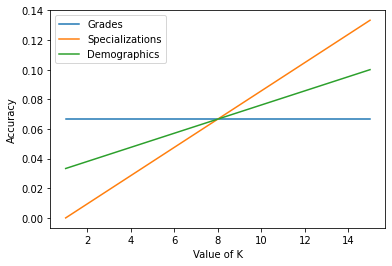

In [66]:
def optimal_k(X_train, y_train, X_test, y_test):
    k_range = (1, 15)
    scores = {}
    scores_list = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        scores[k] = metrics.accuracy_score(y_test, y_pred)
        scores_list.append(metrics.accuracy_score(y_test, y_pred))
    return k_range, scores_list

k_range1, scores1 = optimal_k(X_train1, np.ravel(y_train1), X_test1, np.ravel(y_test1))
plt.plot(k_range1, scores1, label="Grades")

k_range2, scores2 = optimal_k(X_train2, np.ravel(y_train2), X_test2, np.ravel(y_test2))
plt.plot(k_range2, scores2, label = "Specializations")

k_range3, scores3 = optimal_k(X_train3, np.ravel(y_train3), X_test3, np.ravel(y_test3))
plt.plot(k_range3, scores3, label = "Demographics")

plt.xlabel("Value of K")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

Determine the optimal column configuration for the algorithm